# Warranty

In [ ]:
from typing import Literal
import pandas as pd
from utils import *

X_dataframe = pd.read_csv("../data/X_dataframe.csv")

In [4]:
X_dataframe["warranty"].describe()

count     35243
unique     9536
top          Sí
freq       5107
Name: warranty, dtype: object

In [5]:
X_dataframe["warranty"].value_counts()[:40]

warranty
Sí                                                                                                                                                                                                                                     5107
Sin garantía                                                                                                                                                                                                                           4907
SI                                                                                                                                                                                                                                      545
6 meses                                                                                                                                                                                                                                 489
6 MESES                                        

In [6]:
X_dataframe["warranty"].isnull().sum()

np.int64(54757)

#### 💡 Insights
61% of the data is empty

In [7]:
# Fill with "unknown"
X_dataframe["warranty"] = X_dataframe["warranty"].fillna("unknown")
X_dataframe["warranty"] = X_dataframe["warranty"].apply(lambda x: "unknown" if x == "" else x)
X_dataframe["warranty"].value_counts()

warranty
unknown                                                                                                                                                                                            54757
Sí                                                                                                                                                                                                  5107
Sin garantía                                                                                                                                                                                        4907
SI                                                                                                                                                                                                   545
6 meses                                                                                                                                                                                    

#### 💡 Insights
Still a lot of unconsistency in the warranty responses

In [ ]:
def typical_string_processing(x: str) -> str:
    """
    This function removes accent marks, converts to lowercase, removes dots and trims the string

    Args:
        x: str, the string to process

    Returns:
        str, the processed string
    """
    tildes = "áéíóú"
    no_tildes = "aeiou"
    x = x.lower()
    x = x.strip()
    for i in range(len(tildes)):
        x = x.replace(tildes[i], no_tildes[i])
    return x


def find_warranty_magnitude(x: str) -> str:
    """
    This function finds the magnitude of the warranty.
    It checks if the magnitude is in years, months, weeks or days.

    Args:
        x: str, the string to process

    Returns:
        str, the processed string


    """
    if "año" in x or "ano" in x.split(" ") or "anos" in x.split(" "):
        return "años"
    elif "mes" in x:
        return "meses"
    elif "semana" in x:
        return "semanas"
    elif "dia" in x:
        try:
            days = int(x.split("dia")[0].split(" ")[-2])
            if days > 365:
                return "años"
            elif days > 30:
                return "meses"
            elif days > 7:
                return "semanas"
            else:
                return "dias"
        except (ValueError, IndexError):
            return x
    elif "horas" in x:
        return "dias"  # Hypothesis: the warranty is for 24 or 48 hours
    else:
        return x


def warranty_de_fabricacion(x: str) -> str:
    """
    This function checks if the warranty is from the factory.

    Args:
        x: str, the string to process

    Returns:
        str, the processed string
    """
    if "fabrica" in x or "origen" in x:  # Hypothesis: the warranty is from the factory
        return "de fabrica"
    else:
        return x


def yes_no_warranty(x):
    if x not in ["años", "meses", "semanas", "dias", "de fabrica", "usado", "a nuevo"]:
        x = x.replace(".", "")
        if "si" in x.split(" ") or "con garantia" in x or "garantia total" in x:
            return "si"
        elif "sin garantia" in x:
            return "no"
        else:
            return "otro"
    else:
        return x


def warranty_estado(x: str) -> str:
    """
    This function checks if in the warranty the seller mentions the state of the item.

    Args:
        x: str, the string to process

    Returns:
        str, the processed string. Can be "a nuevo", "usado", "otro", "de fabrica", "años", "meses", "semanas", "dias", "si", "no"
    """
    if x not in ["años", "meses", "semanas", "dias", "de fabrica"]:
        x = typical_string_processing(x)
        if "nuevo" in x:
            return "a nuevo"
        elif "usado" in x:
            if "devolucion" not in x or "sido" not in x:
                return "usado"
            else:
                return "otro"
        elif "reparado" in x:
            return "usado"
        elif (
            "estado" in x or "excelentes condiciones" in x or "buenas condiciones" in x
        ):
            return "usado"
        else:
            return x
    else:
        return x


def warranty_string_processing(
    x: str,
) -> Literal[
    "a nuevo",
    "usado",
    "otro",
    "de fabrica",
    "años",
    "meses",
    "semanas",
    "dias",
    "si",
    "no",
    "unknown",
]:
    """
    This function processes the warranty string.
    It removes accent marks, converts to lowercase, removes dots and trims the string.
    It finds the magnitude of the warranty.
    It checks if the warranty is from the factory.
    It checks if in the warranty the seller mentions the state of the item.

    Args:
        x: str, the string to process

    Returns:
        str, the processed string.
        Can be "a nuevo", "usado", "otro", "de fabrica", "años", "meses", "semanas", "dias", "si", "no","unknown"
    """
    if isinstance(x, str) and x != "unknown":
        x = typical_string_processing(x)
        x = find_warranty_magnitude(x)
        x = warranty_de_fabricacion(x)
        x = warranty_estado(x)
        x = yes_no_warranty(x)
    return x


In [9]:
X_dataframe["processed_warranty"] = X_dataframe["warranty"].apply(
    warranty_string_processing
)

In [11]:
X_dataframe["processed_warranty"].value_counts()

processed_warranty
unknown       54757
otro           9948
si             7842
no             4933
meses          4856
años           2603
de fabrica     2585
usado          1059
a nuevo         735
semanas         463
dias            219
Name: count, dtype: int64

In [14]:
X_dataframe.loc[X_dataframe["processed_warranty"] == "otro"]["warranty"].value_counts()[:20]

warranty
MI REPUTACION                                                                                                                                                                     192
MIS CALIFICACIONES                                                                                                                                                                151
TODOS MIS PRODUCTOS ESTAN 100 % GARANTIZADOS,DE NO ESTAR CONFORME CON LOS MISMOS   SE REINTEGRARA  EL IMPORTE DEL PRODUCTO,CONTRA DEVOLUCION DEL ARTICULO                         148
Oferta con confianza - Revisa nuestras Calificaciones!!                                                                                                                           127
SE GARANTIZA LA DESCRIPCIÓN.                                                                                                                                                      113
Se entrega en caja sellada, el cadete que lo entrega no sabe el contenido. En cas

#### 💡 Insights  
Most of the warranty descriptions categorized as **“otro”** provide little useful information.  
Next, we will analyze whether the other identified warranty categories show any relationship with item condition.

In [15]:
res = column_analysis("processed_warranty", X_dataframe)
display(res)

,n,prop_used,ci_lower,ci_upper
processed_warranty,,,,
usado,1059,0.877243,0.856103,0.895655
no,4933,0.653558,0.640164,0.666712
unknown,54757,0.516500,0.512313,0.520685
si,7842,0.509691,0.498625,0.520748
otro,9948,0.455669,0.445902,0.465472
dias,219,0.415525,0.352260,0.481703
semanas,463,0.231102,0.195011,0.271617
a nuevo,735,0.088435,0.069991,0.111160
años,2603,0.077219,0.067575,0.088108


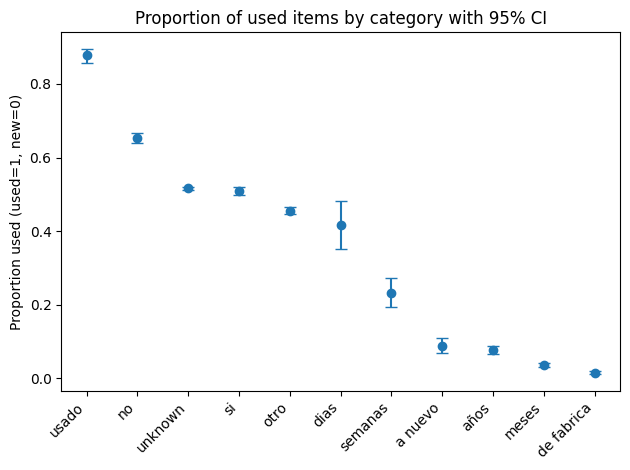

In [17]:
plot_column_analysis(res)

#### 💡 Insights  
Several warranty description categories are strong predictors of item condition.  
For example:  
- **“usado”** and **“no”** are highly associated with used items.  
- **“de fábrica”**, **“meses”**, **“a nuevo”**, and **“años”** are strongly associated with new items.  

This indicates that warranty information can be a valuable feature for classification.

For the training dataset, we will only have the `processed_warranty` feature